<a href="https://colab.research.google.com/github/Onirb/pt-variant-classification/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages


In [1]:
!pip install accelerate -U

!pip install --quiet datasets
!pip install tiktoken
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
from sklearn.metrics import f1_score
from torch import optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from datasets import load_dataset, Dataset as HFDataset
from tqdm import tqdm
from datasets import DatasetDict, Dataset
from datasets import load_dataset

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device {DEVICE} available.")

Device cuda available.


# Load data

In [4]:
dataset = load_dataset("cc4051/pt_vid")
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/476 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/4.76M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11717 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2570 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 11717
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2570
    })
})

In [5]:
label_map = {
    "PT-PT": 0,
    "PT-BR": 1
}

def map_label(label):
    return label_map.get(label, None)  # Return None for labels not in the label_map
n_classes = len(label_map)

Load the data from [DSL-TL](https://https://github.com/LanguageTechnologyLab/DSL-TL/blob/main/README.md)

In [7]:
# Load the new dataset
new_data = pd.read_csv('PT_train.tsv', sep='\t', header=None, names=[ 'text', 'label'])
new_data


,text,label
155907,Confira a matéria que foi ao ar nesta segunda-...,PT-BR
155413,O projeto será apresentado pelo presidente em ...,PT-BR
173135,As nomeações terminam às 12 horas do próximo d...,PT-BR
156093,“Um programa imperdível para quem vai a Porto ...,PT-BR
173776,A quebra na venda de casas surge numa altura e...,PT-PT
...,...,...
174229,Além das habituais palavras de ordem e cartaze...,PT-PT
156114,"Das 750 sorologias realizadas no CRT-DST/Aids,...",PT-BR
154506,A descoberta do vírus é resultado da análise d...,PT-BR
156811,"Na cerimônia, Laerte aproveitou para ratificar...",PT-BR


In [8]:
# Convert the DataFrame to a Dataset object
dataset2 = Dataset.from_pandas(new_data)
dataset2


Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 3467
})

In [9]:
# Combine the datasets into a DatasetDict
combined_dataset_dict = DatasetDict({
    'train': dataset['train'],
    'test': dataset['test'],
    'additional': dataset2
})

In [10]:
# Remove the '__index_level_0__' column
def remove_index_column(example):
    example.pop('__index_level_0__', None)
    return example

cleaned_additional_dataset = combined_dataset_dict['additional'].map(remove_index_column, batched=False)

# Map the labels and filter out rows with None labels
def process_labels(example):
    example['label'] = map_label(example['label'])
    return example

cleaned_additional_dataset = cleaned_additional_dataset.map(process_labels).filter(lambda example: example['label'] is not None)



Map:   0%|          | 0/3467 [00:00<?, ? examples/s]

Map:   0%|          | 0/3467 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3467 [00:00<?, ? examples/s]

In [11]:
combined_dataset_dict = DatasetDict({
    'train': combined_dataset_dict['train'],
    'test': combined_dataset_dict['test'],
    'additional': cleaned_additional_dataset
})

In [12]:
combined_dataset_dict['additional']

Dataset({
    features: ['text', 'label'],
    num_rows: 3047
})

In [13]:

# Combine the 'train' and 'additional' datasets and reset the index
combined_train_df = pd.concat([combined_dataset_dict['train'].to_pandas(), combined_dataset_dict['additional'].to_pandas()]).reset_index(drop=True)

# Drop the __index_level_0__ column if it exists
if '__index_level_0__' in combined_train_df.columns:
    combined_train_df = combined_train_df.drop(columns=['__index_level_0__'])

# Convert the combined DataFrame back to a Dataset
combined_train_dataset = Dataset.from_pandas(combined_train_df)

# Create the new DatasetDict with combined train and existing test datasets
final_dataset_dict = DatasetDict({
    'train': combined_train_dataset,
    'test': combined_dataset_dict['test']
})

# Verify the combined dataset
print(final_dataset_dict)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 14764
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2570
    })
})


## Tockenize

In [14]:
corpus = "".join(final_dataset_dict['train']["text"]) # one giant sentence

# we will define our vocab to be composed of
vocab = list(set(corpus.lower()))

# Special padding token
pad_token = "<pad>"
vocab.append(pad_token)

# Special unknown token
unk_token = "<unk>"
vocab.append(unk_token)

n_tokens = len(vocab)

print("Number of tokens in the vocab: ", n_tokens)

Number of tokens in the vocab:  110


In [15]:
tkn2id = {v: k for k, v in enumerate(vocab)}

pad_token_id = tkn2id[pad_token]
unk_token_id = tkn2id[unk_token]


def tokenize(text):
    return [tkn2id[c] if c in tkn2id else unk_token_id for c in text.lower()]

## Model and train define

In [16]:

class Model(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        hidden_size: int,
        n_classes: int,
        n_layers: int
    ):
        super(Model, self).__init__()
        self.embedding = nn.Embedding(
            vocab_size,
            hidden_size,
            padding_idx=pad_token_id
        )
        self.rnn = nn.LSTM(
            hidden_size,
            hidden_size,
            batch_first=True,
            num_layers=n_layers,
        )
        self.fc = nn.Linear(hidden_size, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = F.relu(x)
        x = x[:, -1, :]  # get the last hidden state
        logits = self.fc(x)
        return logits

In [17]:
from torch.utils.data import DataLoader, Dataset
# nao remover o load, da um bug

class VIdDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        """The max_length limits the number of tokens in the text.
        Texts that are longer are truncated, and shorter texts are padded."""
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.pad_token_id = pad_token_id

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        text = item["text"]
        tokens = self.tokenizer(text)
        if len(tokens) < self.max_length:  # padding
            padding = [self.pad_token_id] * (self.max_length - len(tokens))
            tokens += padding
        else:  # truncate
            tokens = tokens[: self.max_length]

        label = item["label"]
        return {
            "tokens": torch.tensor(tokens),
            "label": torch.tensor(label),
        }

In [18]:
# train with f1 score trying to deal with the not balanced dataset
def train(model: nn.Module, train_loader: DataLoader, n_epochs: int, lr: float):
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criteria = nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        model.train()

        n_steps = len(train_loader)
        progress_bar = tqdm(
            total=n_steps, desc=f"Epoch {epoch+1}", position=0, leave=True
        )
        total_loss = 0
        all_y_true = []
        all_y_pred = []

        for idx, batch in enumerate(train_loader):
            optimizer.zero_grad()
            x = batch["tokens"].to(DEVICE)
            y = batch["label"].to(DEVICE)
            logits = model(x)
            loss = criteria(logits, y)
            loss.backward()
            optimizer.step()

            # logging
            total_loss += loss.item()
            y_pred = logits.argmax(dim=1)
            all_y_true.extend(y.cpu().numpy())
            all_y_pred.extend(y_pred.cpu().numpy())

            if idx % 10 == 0:  # Adjust the frequency of logging as needed
                f1 = f1_score(all_y_true, all_y_pred, average='weighted')
                progress_bar.set_postfix(
                    {
                        "loss": total_loss / (idx + 1),
                        "f1_score": f1,
                    }
                )
            progress_bar.update()

        # Log F1 score for the epoch
        f1 = f1_score(all_y_true, all_y_pred, average='weighted')
        progress_bar.set_postfix({"f1_score": f1})
        progress_bar.close()


In [19]:
def evaluate(model: nn.Module, testset: Dataset):
    test_loader = DataLoader(testset, batch_size=32, shuffle=False)

    model.eval()
    y_true, y_pred = [], []
    for batch in test_loader:
        x = batch["tokens"].to(DEVICE)
        y_true += batch["label"].tolist()
        logits = model(x)
        y_pred += logits.argmax(dim=1).tolist()

    return y_true, y_pred

In [20]:

def predict_and_save(model: torch.nn.Module, test_loader: DataLoader, output_file: str):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in test_loader:
            x = batch["tokens"].to(DEVICE)
            ids = batch["id"].tolist()
            logits = model(x)
            y_pred = logits.argmax(dim=1).tolist()

            for id_, label in zip(ids, y_pred):
                predictions.append({"ID": id_, "Label": label})

    # Save predictions to a CSV file
    predictions_df = pd.DataFrame(predictions)
    predictions_df.to_csv(output_file, index=False)

# Train

## Using LSTM

In [21]:
train2_dataset = VIdDataset(final_dataset_dict['train'], tokenize)

In [22]:

train_loader2 = DataLoader(
    dataset=train2_dataset,
    batch_size=64,
    shuffle=True,
    drop_last=True
  )

In [23]:
 model = Model(
    vocab_size=n_tokens,
    hidden_size=140,
    n_classes=n_classes,
    n_layers=2
    ).to(DEVICE)

In [24]:
train(
    model=model,
    train_loader=train_loader2,
    n_epochs=20,
    lr=5e-3,
)

Epoch 20: 100%|██████████| 230/230 [00:25<00:00,  9.03it/s, f1_score=0.936]


## Evaluation LSTM

In [25]:
testset = VIdDataset(dataset["test"], tokenize)
y_true_test, y_pred_test = evaluate(model, testset)

In [26]:
# Verify label_map and n_classes
print("label_map:", label_map)
print("n_classes:", n_classes)

# Ensure label_map contains all necessary labels
label_map = {i: f"Class_{i}" for i in range(n_classes)}
print("label_map:", label_map)

# Generate target names
target_names = [label_map[i] for i in range(n_classes)]

# Generate and print classification report
report = classification_report(y_true_test, y_pred_test, target_names=target_names)
print(report)


label_map: {'PT-PT': 0, 'PT-BR': 1}
n_classes: 2
label_map: {0: 'Class_0', 1: 'Class_1'}
              precision    recall  f1-score   support

     Class_0       0.91      0.89      0.90      1335
     Class_1       0.88      0.90      0.89      1235

    accuracy                           0.90      2570
   macro avg       0.90      0.90      0.90      2570
weighted avg       0.90      0.90      0.90      2570



In [27]:
# Define the path where you want to save the model
model_save_path = "/modelLTSM.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /modelLTSM.pth


### Tuning

In [28]:
def objective(trial):
    # Define the hyperparameters to tune with steps
    hidden_size = trial.suggest_int('hidden_size', 120, 240, step=10)  # step size of 10
    n_layers = trial.suggest_int('n_layers', 2, 3, step=1)  # step size of 1
    learning_rate = trial.suggest_categorical('lr', [1e-3, 5e-3])  # discrete values for learning rate

    # Initialize the model with these hyperparameters
    model = Model(
        vocab_size=n_tokens,
        hidden_size=hidden_size,
        n_classes=n_classes,
        n_layers=n_layers
    ).to(DEVICE)

    # Train the model
    train(model, train_loader2, n_epochs=5, lr=learning_rate)

    # Evaluate the model
    y_true, y_pred = evaluate(model, testset)

    # Calculate and return the metric to optimize (e.g., F1 score)
    report = classification_report(y_true, y_pred, output_dict=True)
    f1_score = report['weighted avg']['f1-score']

    return f1_score

# Run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print(study.best_params)

[I 2025-03-22 21:07:14,028] A new study created in memory with name: no-name-b067cdb9-b06c-46d0-b969-03f71b520ff7
Epoch 5: 100%|██████████| 230/230 [00:19<00:00, 11.85it/s, f1_score=0.82]
[I 2025-03-22 21:08:53,074] Trial 0 finished with value: 0.8402102797441882 and parameters: {'hidden_size': 220, 'n_layers': 2, 'lr': 0.005}. Best is trial 0 with value: 0.8402102797441882.
Epoch 5: 100%|██████████| 230/230 [00:43<00:00,  5.33it/s, f1_score=0.704]
[I 2025-03-22 21:12:34,649] Trial 1 finished with value: 0.6912785335504966 and parameters: {'hidden_size': 180, 'n_layers': 2, 'lr': 0.001}. Best is trial 0 with value: 0.8402102797441882.
Epoch 5: 100%|██████████| 230/230 [00:27<00:00,  8.40it/s, f1_score=0.732]
[I 2025-03-22 21:14:53,075] Trial 2 finished with value: 0.7509225785831418 and parameters: {'hidden_size': 210, 'n_layers': 3, 'lr': 0.005}. Best is trial 0 with value: 0.8402102797441882.
Epoch 5: 100%|██████████| 230/230 [00:19<00:00, 11.92it/s, f1_score=0.8]
[I 2025-03-22 21:16

{'hidden_size': 210, 'n_layers': 2, 'lr': 0.005}


### Predicting over Test.csv

In [29]:
# Load the test dataset
test_dataset = load_dataset('csv', data_files={'test': 'test.csv'})['test']
test_dataset

Generating test split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['id', 'text'],
    num_rows: 2570
})

In [30]:
def tokenize_batch(batch):
    tokens = [tkn2id.get(c, unk_token_id) for c in batch['text'].lower()]
    if len(tokens) < max_length:
        tokens += [pad_token_id] * (max_length - len(tokens))
    else:
        tokens = tokens[:max_length]
    return {'tokens': tokens}


In [31]:
max_length = 512  # Define max_length according to your model's requirements

# Tokenize the dataset
tokenized_test_dataset = test_dataset.map(tokenize_batch, batched=False)

Map:   0%|          | 0/2570 [00:00<?, ? examples/s]

In [32]:
class HuggingFaceDatasetAdapter(Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {
            "id": item["id"],
            "tokens": torch.tensor(item["tokens"]),
        }

# Create a DataLoader
test_loader = DataLoader(HuggingFaceDatasetAdapter(tokenized_test_dataset), batch_size=32, shuffle=False)


In [33]:


output_csv_path = '/predictionsLTSM.csv'
predict_and_save(model, test_loader, output_csv_path)

## CNN

## Define Model

In [34]:
class ComplexCNNModel(nn.Module):
    def __init__(self, vocab_size: int, hidden_size: int, n_classes: int, kernel_size: int = 3, dropout_rate: float = 0.5):
        super(ComplexCNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=pad_token_id)

        # First convolutional block
        self.conv1 = nn.Conv1d(hidden_size, hidden_size, kernel_size, padding=1)
        self.pool1 = nn.MaxPool1d(2)
        self.dropout1 = nn.Dropout(dropout_rate)

        # Second convolutional block
        self.conv2 = nn.Conv1d(hidden_size, hidden_size * 2, kernel_size, padding=1)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout2 = nn.Dropout(dropout_rate)

        # Third convolutional block
        self.conv3 = nn.Conv1d(hidden_size * 2, hidden_size * 4, kernel_size, padding=1)
        self.pool3 = nn.MaxPool1d(2)
        self.dropout3 = nn.Dropout(dropout_rate)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size * 4, hidden_size)
        self.fc2 = nn.Linear(hidden_size, n_classes)

    def forward(self, x):
        x = self.embedding(x).transpose(1, 2)  # (batch_size, hidden_size, seq_length)

        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.dropout3(x)

        x = F.max_pool1d(x, x.size(2)).squeeze(2)  # Global max pooling
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        logits = self.fc2(x)

        return logits

## Tune and Train


In [35]:
import optuna
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report

# Define the model class
class ComplexCNNModel(nn.Module):
    def __init__(self, vocab_size: int, hidden_size: int, n_classes: int, n_conv_layers: int, kernel_size: int = 3, dropout_rate: float = 0.5):
        super(ComplexCNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=pad_token_id)

        self.conv_layers = nn.ModuleList()
        in_channels = hidden_size
        for i in range(n_conv_layers):
            out_channels = hidden_size * (2 ** i)
            self.conv_layers.append(nn.Conv1d(in_channels, out_channels, kernel_size, padding=1))
            in_channels = out_channels

        self.pool = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(dropout_rate)
        self.global_pool = nn.AdaptiveMaxPool1d(1)

        self.fc1 = nn.Linear(hidden_size * (2 ** (n_conv_layers - 1)), hidden_size)
        self.fc2 = nn.Linear(hidden_size, n_classes)

    def forward(self, x):
        x = self.embedding(x).transpose(1, 2)
        for conv_layer in self.conv_layers:
            x = F.relu(conv_layer(x))
            x = self.pool(x)
            x = self.dropout(x)

        x = self.global_pool(x).squeeze(2)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        logits = self.fc2(x)
        return logits



In [36]:
# Define the objective function
def objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 140, 200, step=10)
    n_conv_layers = trial.suggest_int('n_conv_layers', 2, 3)
    lr = trial.suggest_float('lr', 9e-4, 2e-3, log=True)

    model = ComplexCNNModel(vocab_size=n_tokens, hidden_size=hidden_size, n_classes=n_classes, n_conv_layers=n_conv_layers).to(DEVICE)

    train(model, train_loader2, n_epochs=10, lr=lr)
    y_true, y_pred = evaluate(model, testset)
    report = classification_report(y_true, y_pred, target_names=[label_map[i] for i in range(n_classes)], output_dict=True)

    return report['accuracy']

# Create the study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Get the best trial
best_trial = study.best_trial
print(f'Best trial: {best_trial.params}')

[I 2025-03-22 23:12:41,006] A new study created in memory with name: no-name-bb6d390c-a7d9-4924-9857-1e96a7b342b8
Epoch 10: 100%|██████████| 230/230 [00:10<00:00, 22.59it/s, f1_score=0.853]
[I 2025-03-22 23:14:23,210] Trial 0 finished with value: 0.8933852140077821 and parameters: {'hidden_size': 180, 'n_conv_layers': 3, 'lr': 0.0012695482235617218}. Best is trial 0 with value: 0.8933852140077821.
Epoch 10: 100%|██████████| 230/230 [00:08<00:00, 26.39it/s, f1_score=0.86]
[I 2025-03-22 23:15:49,896] Trial 1 finished with value: 0.9023346303501946 and parameters: {'hidden_size': 150, 'n_conv_layers': 3, 'lr': 0.0014342139776912935}. Best is trial 1 with value: 0.9023346303501946.
Epoch 10: 100%|██████████| 230/230 [00:07<00:00, 31.17it/s, f1_score=0.873]
[I 2025-03-22 23:17:02,519] Trial 2 finished with value: 0.8396887159533074 and parameters: {'hidden_size': 170, 'n_conv_layers': 2, 'lr': 0.0013956807048831473}. Best is trial 1 with value: 0.9023346303501946.
Epoch 10: 100%|██████████|

Best trial: {'hidden_size': 200, 'n_conv_layers': 2, 'lr': 0.0009594010819376687}


In [37]:
# Save the best model parameters
torch.save(best_trial.params, 'model_cnn_params.pth')

# Load the best parameters
best_params = torch.load('model_cnn_params.pth')

# Initialize the model with the best parameters
best_model = ComplexCNNModel(vocab_size=n_tokens,
                             hidden_size=best_params['hidden_size'],
                             n_classes=n_classes,
                             n_conv_layers=best_params['n_conv_layers']).to(DEVICE)

# Train and evaluate the best model for more epochs
train(best_model, train_loader2, n_epochs=5, lr=best_params['lr'])
y_true_complex_cnn, y_pred_complex_cnn = evaluate(best_model, testset)
print("Complex CNN Classification Report after 5 more epochs:")
print(classification_report(y_true_complex_cnn, y_pred_complex_cnn, target_names=[label_map[i] for i in range(n_classes)]))

train(best_model, train_loader2, n_epochs=10, lr=best_params['lr'])
y_true_complex_cnn, y_pred_complex_cnn = evaluate(best_model, testset)
print("Complex CNN Classification Report after 10 more epochs:")
print(classification_report(y_true_complex_cnn, y_pred_complex_cnn, target_names=[label_map[i] for i in range(n_classes)]))

train(best_model, train_loader2, n_epochs=15, lr=best_params['lr'])
y_true_complex_cnn, y_pred_complex_cnn = evaluate(best_model, testset)
print("Complex CNN Classification Report after 15 more epochs:")
print(classification_report(y_true_complex_cnn, y_pred_complex_cnn, target_names=[label_map[i] for i in range(n_classes)]))

train(best_model, train_loader2, n_epochs=20, lr=best_params['lr'])
y_true_complex_cnn, y_pred_complex_cnn = evaluate(best_model, testset)
print("Complex CNN Classification Report after 20 more epochs:")
print(classification_report(y_true_complex_cnn, y_pred_complex_cnn, target_names=[label_map[i] for i in range(n_classes)]))

# Save the trained model
torch.save(best_model.state_dict(), 'best_model_state_dict.pth')

Epoch 5: 100%|██████████| 230/230 [00:08<00:00, 27.86it/s, f1_score=0.854]


Complex CNN Classification Report after 5 more epochs:
              precision    recall  f1-score   support

     Class_0       0.99      0.68      0.80      1335
     Class_1       0.74      0.99      0.85      1235

    accuracy                           0.83      2570
   macro avg       0.86      0.83      0.82      2570
weighted avg       0.87      0.83      0.82      2570



Epoch 10: 100%|██████████| 230/230 [00:08<00:00, 27.36it/s, f1_score=0.899]


Complex CNN Classification Report after 10 more epochs:
              precision    recall  f1-score   support

     Class_0       0.96      0.91      0.93      1335
     Class_1       0.91      0.95      0.93      1235

    accuracy                           0.93      2570
   macro avg       0.93      0.93      0.93      2570
weighted avg       0.93      0.93      0.93      2570



Epoch 15: 100%|██████████| 230/230 [00:07<00:00, 28.76it/s, f1_score=0.919]


Complex CNN Classification Report after 15 more epochs:
              precision    recall  f1-score   support

     Class_0       0.95      0.93      0.94      1335
     Class_1       0.93      0.95      0.94      1235

    accuracy                           0.94      2570
   macro avg       0.94      0.94      0.94      2570
weighted avg       0.94      0.94      0.94      2570



Epoch 20: 100%|██████████| 230/230 [00:08<00:00, 28.15it/s, f1_score=0.931]


Complex CNN Classification Report after 15 more epochs:
              precision    recall  f1-score   support

     Class_0       0.95      0.95      0.95      1335
     Class_1       0.95      0.94      0.95      1235

    accuracy                           0.95      2570
   macro avg       0.95      0.95      0.95      2570
weighted avg       0.95      0.95      0.95      2570



In [38]:
# Define the path where you want to save the model
model_save_path = "/modelCNN.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /modelCNN.pth


## Predictions CNN

In [39]:
from datasets import load_dataset

# Load the test dataset
test_dataset = load_dataset('csv', data_files={'test': 'test.csv'})['test']
test_dataset


Dataset({
    features: ['id', 'text'],
    num_rows: 2570
})

In [40]:
def tokenize_batch(batch):
    tokens = [tkn2id.get(c, unk_token_id) for c in batch['text'].lower()]
    if len(tokens) < max_length:
        tokens += [pad_token_id] * (max_length - len(tokens))
    else:
        tokens = tokens[:max_length]
    return {'tokens': tokens}

In [41]:
max_length = 512  # Define max_length according to your model's requirements

# Tokenize the dataset
tokenized_test_dataset = test_dataset.map(tokenize_batch, batched=False)

In [42]:
from torch.utils.data import DataLoader

class HuggingFaceDatasetAdapter(Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {
            "id": item["id"],
            "tokens": torch.tensor(item["tokens"]),
        }

# Create a DataLoader
test_loader = DataLoader(HuggingFaceDatasetAdapter(tokenized_test_dataset), batch_size=64, shuffle=False)

In [43]:
output_csv_path = '/predictionsCNN.csv'
predict_and_save(best_model, test_loader, output_csv_path)

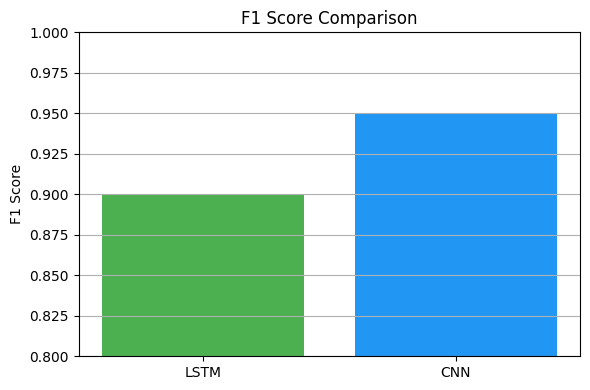

In [46]:
import matplotlib.pyplot as plt
models = ['LSTM', 'CNN']
f1_scores = [0.90, 0.95]  # <-- edite este valor depois

plt.figure(figsize=(6, 4))
plt.bar(models, f1_scores, color=['#4CAF50', '#2196F3'])
plt.title("F1 Score Comparison")
plt.ylabel("F1 Score")
plt.ylim(0.8, 1.0)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("/f1_score_comparison.png")
plt.show()